# Create training data

Schema:
* id: (int) unique ID for each doc
* tokens: (list) words or groups of words 
* bboxes: (list) bounding box for each token (x1, y1, x2, y2)
* ner_tags: (int) the entity tag corresponding to each token
* image: PIL Image

In [2]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 8.1 MB/s eta 0:00:0000:0100:01


In [42]:
from typing import Any, Optional, Union

import fitz  # PyMuPDF
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

from mozilla_sec_eia.utils import GCSArchive

In [155]:
# do we actually need the headers?
id_to_label_full = {
    0: "O",
    1: "B-Header_Subsidiary",
    2: "I-Header_Subsidiary",
    3: "B-Body_Subsidiary",
    4: "I-Body_Subsidiary",
    5: "B-Header_Loc",
    6: "I-Header_Loc",
    7: "B-Body_Loc",
    8: "I-Body_Loc",
    9: "B-Header_Own_Per",
    10: "I-Header_Own_Per",
    11: "B-Body_Own_Per",
    12: "I-Body_Own_Per"
}
id_to_label_small = {
    0: "O",
    1: "B-Subsidiary",
    2: "I-Subsidiary",
    3: "B-Loc",
    4: "I-Loc",
    5: "B-Own_Per",
    6: "I-Own_Per"
}


In [3]:
# copied from well gas project wellgas/features/extract_text.py
def extract_pdf_data_from_page(page: fitz.Page) -> dict[str, pd.DataFrame]:
    """Parse PDF page data."""
    contents = _parse_page_contents(page)
    meta = {
        "rotation_degrees": [page.rotation],
        "origin_x_pdf_coord": [page.rect[0]],
        "origin_y_pdf_coord": [page.rect[1]],
        "width_pdf_coord": [page.rect[2] - page.rect[0]],
        "height_pdf_coord": [page.rect[3] - page.rect[1]],
        "has_images": [not contents["image"].empty],
        "has_text": [not contents["pdf_text"].empty],
        "page_num": [page.number],
    }
    if not contents["image"].empty:
        img_area = (
            contents["image"]
            .eval(
                "((bottom_right_x_pdf - top_left_x_pdf)"
                " * (bottom_right_y_pdf - top_left_y_pdf))"
            )
            .sum()
        )
    else:
        img_area = 0
    total_area = meta["width_pdf_coord"][0] * meta["height_pdf_coord"][0]

    meta["image_area_frac"] = [np.float32(img_area / total_area)]
    meta_df = pd.DataFrame(meta).astype(
        {
            "rotation_degrees": np.int16,
            "origin_x_pdf_coord": np.float32,
            "origin_y_pdf_coord": np.float32,
            "width_pdf_coord": np.float32,
            "height_pdf_coord": np.float32,
            "has_images": "boolean",
            "has_text": "boolean",
            "page_num": np.int16,
            "image_area_frac": np.float32,
        }
    )
    meta = dict(page=meta_df)
    for df in contents.values():  # add ID fields
        if not df.empty:
            df["page_num"] = np.int16(page.number)
    return contents | meta


def _parse_page_contents(page: fitz.Page) -> dict[str, pd.DataFrame]:
    """Parse page contents using fitz.TextPage."""
    flags = fitz.TEXTFLAGS_DICT
    textpage = page.get_textpage(flags=flags)
    content = textpage.extractDICT()
    images = []
    text = []
    for block in content["blocks"]:
        if block["type"] == 0:
            parsed = _parse_text_block(block)
            if not parsed.empty:  # can happen when all blocks are whitespace
                text.append(parsed)
        elif block["type"] == 1:
            images.append(_parse_image_block(block))
        else:
            raise ValueError(f"Unknown block type: {block['type']}")
    if text:
        text = pd.concat(text, axis=0, ignore_index=True)
    else:
        text = pd.DataFrame()
    if images:
        images = pd.concat(
            (pd.DataFrame(image) for image in images), axis=0, ignore_index=True
        )
    else:
        images = pd.DataFrame()
    return dict(pdf_text=text, image=images)


def _parse_image_block(img_block: dict[str, Any]) -> pd.DataFrame:
    """Parse an image block from a fitz.TextPage.extractDICT() output."""
    top_left_x_pdf, top_left_y_pdf, bottom_right_x_pdf, bottom_right_y_pdf = img_block[
        "bbox"
    ]
    dpi = min(
        img_block["xres"], img_block["yres"]
    )  # should be equal; min() just in case
    out = pd.DataFrame(
        {
            "img_num": [img_block["number"]],
            "dpi": [dpi],
            "top_left_x_pdf": [top_left_x_pdf],
            "top_left_y_pdf": [top_left_y_pdf],
            "bottom_right_x_pdf": [bottom_right_x_pdf],
            "bottom_right_y_pdf": [bottom_right_y_pdf],
        }
    ).astype(
        {
            "img_num": np.int16,
            "dpi": np.int16,
            "top_left_x_pdf": np.float32,
            "top_left_y_pdf": np.float32,
            "bottom_right_x_pdf": np.float32,
            "bottom_right_y_pdf": np.float32,
        }
    )
    return out


def _parse_text_block(text_block: dict[str, Any]) -> pd.DataFrame:
    """Parse a text block from a fitz.TextPage.extractDICT() output."""
    # block and line bboxes have no information additional to the text bboxes
    out = dict(
        block_num=[],
        line_num=[],
        font_size=[],
        font=[],
        color_srgb=[],
        text=[],
        top_left_x_pdf=[],
        top_left_y_pdf=[],
        bottom_right_x_pdf=[],
        bottom_right_y_pdf=[],
    )
    block_num = text_block["number"]
    for line_num, line in enumerate(text_block["lines"]):
        for span in line["spans"]:  # no numbering, differentiated by font properties
            if span["text"].isspace():  # ignore whitespace spans
                continue
            if _frac_normal_ascii(span["text"]) < 0.7 and len(span["text"]) > 3:
                # Long non-ASCII is likely bad encoding. It has created problems like
                # unbalanced quotes or unquoted \r and \n in CSVs
                out["text"].append("")
            else:
                out["text"].append(span["text"])
            out["block_num"].append(block_num)
            out["line_num"].append(line_num)
            out["font_size"].append(span["size"])
            out["font"].append(span["font"])
            out["color_srgb"].append(span["color"])
            out["top_left_x_pdf"].append(span["bbox"][0])
            out["top_left_y_pdf"].append(span["bbox"][1])
            out["bottom_right_x_pdf"].append(span["bbox"][2])
            out["bottom_right_y_pdf"].append(span["bbox"][3])
    out = pd.DataFrame(out).astype(
        {
            "block_num": np.int16,
            "line_num": np.int16,
            "font_size": np.float32,
            "font": "string",
            "color_srgb": np.int32,
            "text": "string",
            "top_left_x_pdf": np.float32,
            "top_left_y_pdf": np.float32,
            "bottom_right_x_pdf": np.float32,
            "bottom_right_y_pdf": np.float32,
        }
    )
    return out


def _frac_normal_ascii(text: Union[str, bytes]) -> float:
    """Fraction of characters that are normal ASCII characters."""
    # normal characters, from space to tilde, plus whitespace
    # see https://www.asciitable.com/
    sum_ = 0
    if isinstance(text, bytes):
        text = text.decode("utf-8")
    for char in text:
        if (32 <= ord(char) <= 126) or char in "\t\n":
            sum_ += 1
    return sum_ / len(text)


In [4]:

def _render_page(
    pg: fitz.Page, dpi=150, clip: Optional[fitz.Rect] = None
) -> Image.Image:
    """Render a page of a PDF as a PIL.Image object.

    Args:
        pg (fitz.Page): a page of a PDF
        dpi (int, optional): image resolution in pixels per inch. Defaults to 150.
        clip (Optional[fitz.Rect], optional): Optionally render only a subset of the
            page. Defined in PDF coordinates. Defaults to None, which renders the
            full page.

    Returns:
        Image.Image: PDF page rendered as a PIL.Image object
    """
    # 300 dpi is what tesseract recommends. PaddleOCR seems to do fine with half that.
    render: fitz.Pixmap = pg.get_pixmap(dpi=dpi, clip=clip)  # type: ignore
    img = _pil_img_from_pixmap(render)
    return img


def _pil_img_from_pixmap(pix: fitz.Pixmap) -> Image.Image:
    """Convert pyMuPDF Pixmap object to PIL.Image object.

    For some reason pyMuPDF (aka fitz) lets you save images using PIL, but does not
    have any function to convert to PIL objects. Clearly they do this conversion
    internally; they should just expose it. Instead, I had to copy it out from their
    source code.

    Args:
        pix (fitz.Pixmap): a rendered Pixmap

    Returns:
        Image: a PIL.Image object
    """
    # pyMuPDF source code on GitHub is all in SWIG (some kind of C to python code
    # generator) and is unreadable to me. So you have to inspect your local .py files.
    # Adapted from the Pixmap.pil_save method in python3.9/site-packages/fitz/fitz.py
    # I just replaced instances of "self" with "pix"
    cspace = pix.colorspace
    if cspace is None:
        mode = "L"
    elif cspace.n == 1:
        mode = "L" if pix.alpha == 0 else "LA"
    elif cspace.n == 3:
        mode = "RGB" if pix.alpha == 0 else "RGBA"
    else:
        mode = "CMYK"

    img = Image.frombytes(mode, (pix.width, pix.height), pix.samples)
    return img

In [5]:
PDF_POINTS_PER_INCH = 72  # I believe this is standard for all PDFs

def pil_to_cv2(image: Image.Image) -> np.ndarray:  # noqa: C901
    """Convert a PIL Image to an OpenCV image (numpy array)."""
    # copied from https://gist.github.com/panzi/1ceac1cb30bb6b3450aa5227c02eedd3
    # This covers the common modes, is not exhaustive.
    mode = image.mode
    new_image: np.ndarray
    if mode == "1":
        new_image = np.array(image, dtype=np.uint8)
        new_image *= 255
    elif mode == "L":
        new_image = np.array(image, dtype=np.uint8)
    elif mode == "LA" or mode == "La":
        new_image = np.array(image.convert("RGBA"), dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    elif mode == "RGB":
        new_image = np.array(image, dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    elif mode == "RGBA":
        new_image = np.array(image, dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    elif mode == "LAB":
        new_image = np.array(image, dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_LAB2BGR)
    elif mode == "HSV":
        new_image = np.array(image, dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_HSV2BGR)
    elif mode == "YCbCr":
        # XXX: not sure if YCbCr == YCrCb
        new_image = np.array(image, dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_YCrCb2BGR)
    elif mode == "P" or mode == "CMYK":
        new_image = np.array(image.convert("RGB"), dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    elif mode == "PA" or mode == "Pa":
        new_image = np.array(image.convert("RGBA"), dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    else:
        raise ValueError(f"unhandled image color mode: {mode}")

    return new_image


def cv2_to_pil(img: np.ndarray) -> Image.Image:
    """Create PIL Image from numpy pixel array."""
    if len(img.shape) == 2:  # single channel, AKA grayscale
        return Image.fromarray(img)
    else:  # only handle BGR for now
        return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


def display_img_array(img: np.ndarray, figsize=(5, 5), **kwargs):
    """Plot image array for jupyter sessions."""
    plt.figure(figsize=figsize)
    if len(img.shape) == 2:  # grayscale
        return plt.imshow(img, cmap="gray", vmin=0, vmax=255, **kwargs)
    else:
        return plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), **kwargs)


def overlay_bboxes(
    img: np.ndarray, bboxes: np.ndarray, color=(255, 0, 0)
) -> np.ndarray:
    """Overlay bounding boxes of shape N x 4 (x0, y0, x1, y1) on an image."""
    img = img.copy()
    for box in np.round(bboxes, 0).astype(np.int32):  # float to int just in case:
        x0, y0, x1, y1 = box
        cv2.rectangle(img, (x0, y0), (x1, y1), color=color, thickness=1)
    return img


def pdf_coords_to_pixel_coords(coords: np.ndarray, dpi: int) -> np.ndarray:
    """Convert PDF coordinates to pixel coordinates."""
    # For arbitrary PDFs you would need to subtract the origin in PDF coordinates,
    # but since you create these PDFs, you know the origin is (0, 0).
    out = coords * dpi / PDF_POINTS_PER_INCH
    return out

# Create PDFs of Ex. 21's

In [43]:
archive = GCSArchive()
md = archive.get_metadata()

['catalyst-cooperative-mozilla:us-central1:pg-mozilla']: An error occurred while performing refresh. Scheduling another refresh attempt immediately
Traceback (most recent call last):
  File "/Users/katielamb/mambaforge/envs/mozilla-sec-eia/lib/python3.11/site-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/katielamb/mambaforge/envs/mozilla-sec-eia/lib/python3.11/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/katielamb/mambaforge/envs/mozilla-sec-eia/lib/python3.11/socket.py", line 962, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
socket.gaierror: [Errno 8] nodename nor servname

In [52]:
tucson_md = md[md["Company Name"].str.contains("TUCSON")].iloc[[0]]
tucson_filing = archive.get_filings(tucson_md)

In [54]:
with open("tucson_electric.pdf", "wb") as file:
    tucson_filing[0].ex_21.save_as_pdf(file)

In [57]:
# get some random PDFs
sample = md[md.exhibit_21_version.notnull()].sample(3)
filings = archive.get_filings(sample)
for i in range(len(filings)):
    with open(f"test_{i}.pdf", "wb") as file:
        filings[i].ex_21.save_as_pdf(file)

# Demo with one doc

In [103]:
src_path = Path("./wisconsin_electric.pdf")
assert src_path.exists()

In [104]:
# from file
doc = fitz.Document(str(src_path))
doc.is_pdf

True

In [105]:
# from bytes
_bytes = src_path.read_bytes()
from io import BytesIO
doc = fitz.open(stream=BytesIO(_bytes), filetype="pdf")
doc.is_pdf

True

### Extract Text Bboxes

In [106]:
pg = doc[0]
extracted = extract_pdf_data_from_page(pg)
extracted.keys()

dict_keys(['pdf_text', 'image', 'page'])

In [107]:
txt = extracted['pdf_text']
img_info = extracted['image']
pg_meta = extracted['page']
txt.shape, img_info.shape, pg_meta.shape

((22, 11), (0, 0), (1, 9))

In [108]:
txt

,block_num,line_num,font_size,font,color_srgb,text,top_left_x_pdf,top_left_y_pdf,bottom_right_x_pdf,bottom_right_y_pdf,page_num
0,0,0,11.0,Helvetica-Bold,0,Exhibit 21.1,504.791168,83.474442,565.929260,98.621445,0
1,1,0,11.0,Helvetica-Bold,0,WISCONSIN ELECTRIC POWER COMPANY,184.882263,127.074478,410.393280,142.221481,0
2,2,0,11.0,Helvetica-Bold,0,"SUBSIDIARIES AS OF DECEMBER 31, 2016",184.249771,142.274490,411.025818,157.421494,0
3,3,0,10.0,Helvetica,0,The following table includes the subsidiaries ...,29.346460,214.576477,559.586365,228.316483,0
4,3,1,10.0,Helvetica,0,"Wisconsin, as well as the percent of ownership...",29.346460,226.646484,547.326355,240.386490,0
5,3,2,10.0,Helvetica,0,Inc.,29.346460,238.716492,45.466461,252.456497,0
6,4,0,10.0,Helvetica,0,Subsidiary,31.346460,317.576477,78.026466,331.316467,0
7,5,0,10.0,Helvetica,0,State of Incorporation,344.084747,307.576477,439.694733,321.316467,0
8,5,1,10.0,Helvetica,0,or Organization,357.709747,317.979828,426.069763,331.719818,0
9,5,3,10.0,Helvetica,0,Percent Ownership,467.862946,317.576477,552.892944,331.316467,0


### Label the entities

In [109]:
label_col = "ner_tag"

In [167]:
txt.loc[:, label_col] = 0

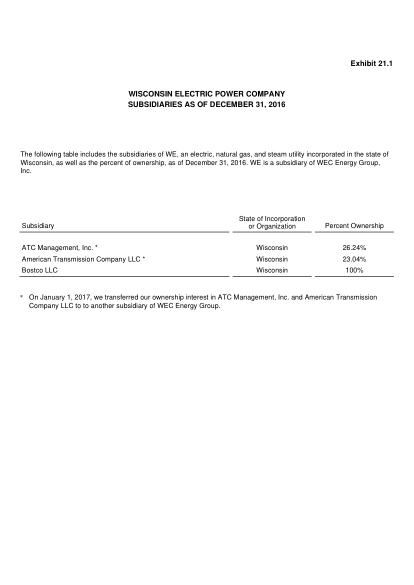

In [168]:
pg_img = _render_page(pg, dpi=50)  # small dpi for notebook display
pg_img

In [169]:
full_pg_img = _render_page(pg)  # full image for dataset

In [152]:
txt

,block_num,line_num,font_size,font,color_srgb,text,top_left_x_pdf,top_left_y_pdf,bottom_right_x_pdf,bottom_right_y_pdf,page_num,ner_tag,id
0,0,0,11.0,Helvetica-Bold,0,Exhibit 21.1,504.791168,83.474442,565.929260,98.621445,0,0,0
1,1,0,11.0,Helvetica-Bold,0,WISCONSIN ELECTRIC POWER COMPANY,184.882263,127.074478,410.393280,142.221481,0,0,0
2,2,0,11.0,Helvetica-Bold,0,"SUBSIDIARIES AS OF DECEMBER 31, 2016",184.249771,142.274490,411.025818,157.421494,0,0,0
3,3,0,10.0,Helvetica,0,The following table includes the subsidiaries ...,29.346460,214.576477,559.586365,228.316483,0,0,0
4,3,1,10.0,Helvetica,0,"Wisconsin, as well as the percent of ownership...",29.346460,226.646484,547.326355,240.386490,0,0,0
5,3,2,10.0,Helvetica,0,Inc.,29.346460,238.716492,45.466461,252.456497,0,0,0
6,4,0,10.0,Helvetica,0,Subsidiary,31.346460,317.576477,78.026466,331.316467,0,1,0
7,5,0,10.0,Helvetica,0,State of Incorporation,344.084747,307.576477,439.694733,321.316467,0,3,0
8,5,1,10.0,Helvetica,0,or Organization,357.709747,317.979828,426.069763,331.719818,0,3,0
9,5,3,10.0,Helvetica,0,Percent Ownership,467.862946,317.576477,552.892944,331.316467,0,5,0


In [160]:
id_to_label_full

{0: 'O',
 1: 'B-Header_Subsidiary',
 2: 'I-Header_Subsidiary',
 3: 'B-Body_Subsidiary',
 4: 'I-Body_Subsidiary',
 5: 'B-Header_Loc',
 6: 'I-Header_Loc',
 7: 'B-Body_Loc',
 8: 'I-Body_Loc',
 9: 'B-Header_Own_Per',
 10: 'I-Header_Own_Per',
 11: 'B-Body_Own_Per',
 12: 'I-Body_Own_Per'}

In [159]:
id_to_label_small

{0: 'O',
 1: 'B-Subsidiary',
 2: 'I-Subsidiary',
 3: 'B-Loc',
 4: 'I-Loc',
 5: 'B-Own_Per',
 6: 'I-Own_Per'}

In [162]:
label_to_indices_full = {
    1: [6],
    3: [10, 13, 16],
    5: [7],
    6: [8],
    7: [11, 14, 17],
    9: [9],
    11: [12, 15, 18]
}

label_to_indices_small = {
    1: [10, 13, 16],
    3: [11, 14, 17],
    5: [12, 15, 18]
}   

In [171]:
for label, indices in label_to_indices_small.items():
    txt.loc[indices, label_col] = label

In [164]:
id_to_color = {
    0: (128, 128, 128),
    1: (0, 255, 0),
    2: (0, 255, 128),
    3: (255, 0, 255),
    4: (128, 0, 255),
    5: (255, 128, 0),
    6: (255, 0, 0)
}   

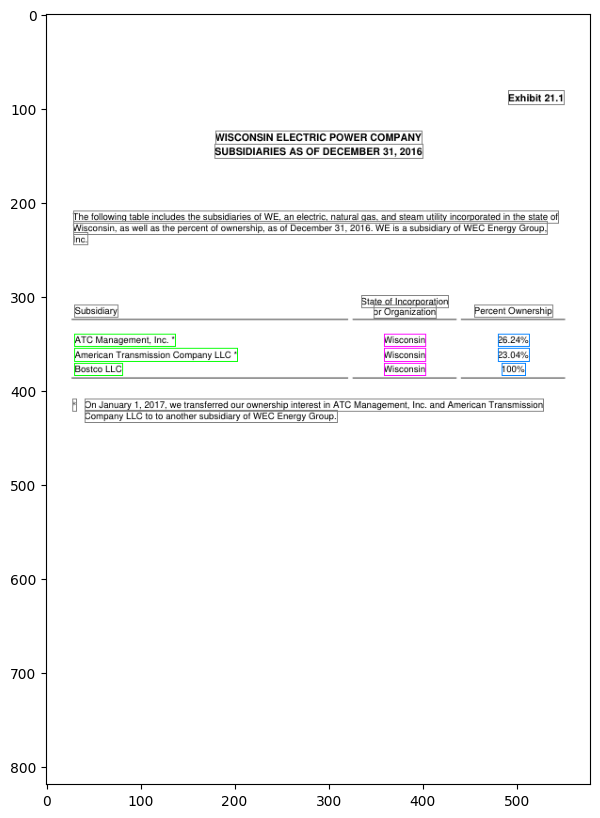

In [172]:
# fix to overlay boxes on pdf and color code it by label
coord_cols = ['top_left_x_pdf', 'top_left_y_pdf', 'bottom_right_x_pdf', 'bottom_right_y_pdf']
dpi = 70
display_img = np.array(_render_page(pg, dpi=dpi))
for tag in id_to_label_small.keys():
    subset = txt[txt[label_col] == tag]
    bboxes = pdf_coords_to_pixel_coords(subset[coord_cols].values, dpi=dpi)
    display_img = overlay_bboxes(display_img, bboxes, color=id_to_color[tag])
display_img_array(display_img, figsize=(10, 10))

In [173]:
txt.loc[:, "id"] = 0
output_df = txt.copy()

# Label Another

In [88]:
src_path = Path("./test_0.pdf")
assert src_path.exists()

In [89]:
# from file
doc = fitz.Document(str(src_path))
doc.is_pdf

True

In [90]:
# from bytes
_bytes = src_path.read_bytes()
from io import BytesIO
doc = fitz.open(stream=BytesIO(_bytes), filetype="pdf")
doc.is_pdf

True

In [91]:
pg = doc[0]
extracted = extract_pdf_data_from_page(pg)
extracted.keys()

dict_keys(['pdf_text', 'image', 'page'])

In [92]:
txt = extracted['pdf_text']
img_info = extracted['image']
pg_meta = extracted['page']
txt.shape, img_info.shape, pg_meta.shape

((14, 11), (0, 0), (1, 9))

In [93]:
txt.loc[:, label_col] = 0

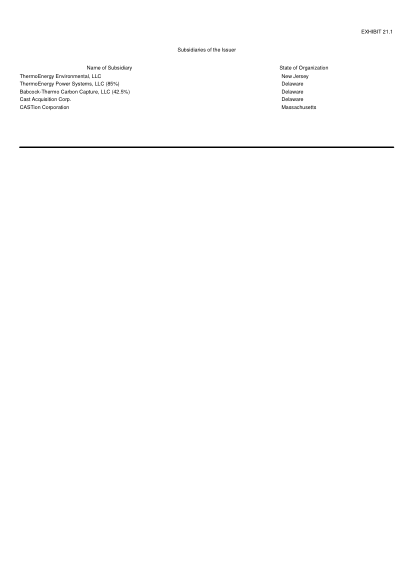

In [94]:
pg_img = _render_page(pg, dpi=50)  # small dpi for notebook display
pg_img

In [95]:
id_to_label

{0: 'no object',
 1: 'header: subsdiary',
 2: 'data: subsidiary',
 3: 'header: location of incorporation',
 4: 'data: location of incorporation',
 5: 'header: ownership percentage',
 6: 'data: ownership percentage'}

In [96]:
txt

,block_num,line_num,font_size,font,color_srgb,text,top_left_x_pdf,top_left_y_pdf,bottom_right_x_pdf,bottom_right_y_pdf,page_num,ner_tag
0,0,0,7.5,Helvetica,0,EXHIBIT 21.1,520.074158,39.918999,565.929138,50.223999,0,0
1,1,0,7.5,Helvetica,0,Subsidiaries of the Issuer,255.536560,66.418999,339.739075,76.723999,0,0
2,2,0,7.5,Helvetica,0,Name of Subsidiary,124.887550,91.919014,190.325027,102.224014,0,0
3,2,2,7.5,Helvetica,0,State of Organization,402.441803,91.919014,472.896790,102.224014,0,0
4,3,0,7.5,Helvetica,0,"ThermoEnergy Environmental, LLC",28.346460,103.918999,145.886444,114.223999,0,0
5,3,3,7.5,Helvetica,0,New Jersey,405.354370,103.918999,444.526886,114.223999,0,0
6,4,0,7.5,Helvetica,0,"ThermoEnergy Power Systems, LLC (85%)",28.346460,115.168999,172.136444,125.473999,0,0
7,4,3,7.5,Helvetica,0,Delaware,405.354370,115.168999,437.026886,125.473999,0,0
8,5,0,7.5,Helvetica,0,"Babcock-Thermo Carbon Capture, LLC (42.5%)",28.346460,126.418991,187.151443,136.723984,0,0
9,5,3,7.5,Helvetica,0,Delaware,405.354370,126.418991,437.026886,136.723984,0,0


In [97]:
label_to_indices = {
    1: [2],
    2: [4, 6, 8, 10, 12],
    3: [3],
    4: [5, 7, 9, 11, 13],
    5: [],
    6: [6, 8]
}

In [98]:
for label, indices in label_to_indices.items():
    txt.loc[indices, label_col] = label

In [99]:
id_to_color = {
    0: (128, 128, 128),
    1: (0, 255, 0),
    2: (0, 255, 128),
    3: (255, 0, 255),
    4: (128, 0, 255),
    5: (255, 128, 0),
    6: (255, 0, 0)
}   

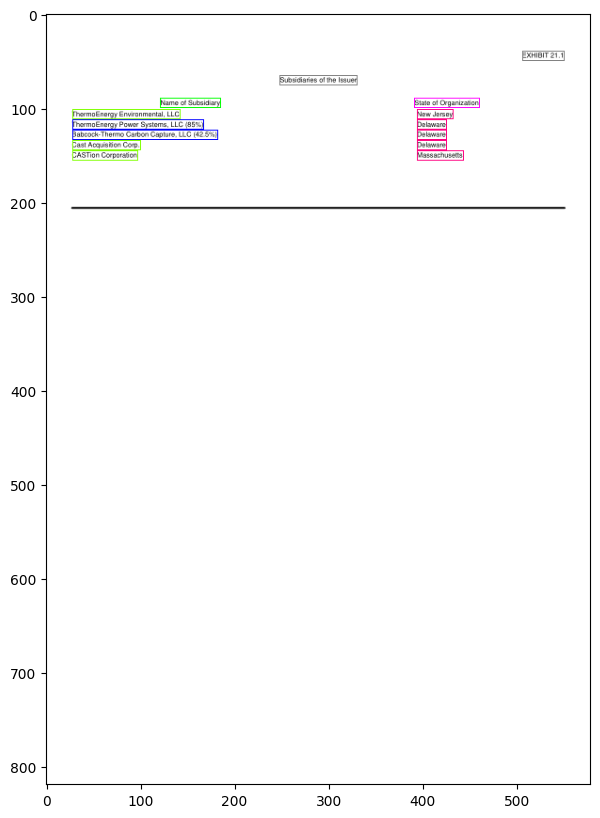

In [100]:
# fix to overlay boxes on pdf and color code it by label
coord_cols = ['top_left_x_pdf', 'top_left_y_pdf', 'bottom_right_x_pdf', 'bottom_right_y_pdf']
dpi = 70
display_img = np.array(_render_page(pg, dpi=dpi))
for tag in id_to_label.keys():
    subset = txt[txt[label_col] == tag]
    bboxes = pdf_coords_to_pixel_coords(subset[coord_cols].values, dpi=dpi)
    display_img = overlay_bboxes(display_img, bboxes, color=id_to_color[tag])
display_img_array(display_img, figsize=(10, 10))

# Combine into one dataframe

In [31]:
# for now make image a filename
output_df = pd.DataFrame(columns=["tokens", "bboxes", "ner_tags", "image"])

In [20]:
doc_id = 0

In [21]:
txt.loc[:, "id"] = doc_id

In [35]:
output_df["tokens"] = txt.groupby("id")["text"].apply(list)
output_df["ner_tags"] = txt.groupby("id")["ner_tag"].apply(list)

In [71]:
output_df.loc[[0]]

,tokens,bboxes,ner_tags,image
id,,,,
0,"[Exhibit 21.1, WISCONSIN ELECTRIC POWER COMPAN...","[504.79117, 83.47444, 565.92926, 98.621445, 18...","[0, 0, 0, 0, 0, 0, 1, 3, 3, 5, 2, 4, 6, 2, 4, ...",NaN


In [82]:
bbox_cols = ["top_left_x_pdf", "top_left_y_pdf", "bottom_right_x_pdf", "bottom_right_y_pdf"]
matrices = {}
for _, group in txt.groupby('id'):
    bbox = group[bbox_cols].values
    matrix = np.reshape(bbox, (len(group), len(bbox_cols)))
    matrices[group.iloc[0]['id']] = matrix

In [87]:
# this isn't so nice, what does the model want as input?
for i, arr in matrices.items():
    output_df.loc[i, "bboxes"] = arr

ValueError: Must have equal len keys and value when setting with an ndarray

In [63]:
# format bboxes to have x1, y1, x2, y2
txt["bboxes"] = txt[["top_left_x_pdf", "top_left_y_pdf", "bottom_right_x_pdf", "bottom_right_y_pdf"]].astype(str).agg(', '.join, axis=1)

In [65]:
output_df["bboxes"] = txt.groupby("id")["bboxes"].apply(list)

In [66]:
output_df

,tokens,bboxes,ner_tags,image
id,,,,
0,"[Exhibit 21.1, WISCONSIN ELECTRIC POWER COMPAN...","[504.79117, 83.47444, 565.92926, 98.621445, 18...","[0, 0, 0, 0, 0, 0, 1, 3, 3, 5, 2, 4, 6, 2, 4, ...",NaN


# Try vendoring DocAI
https://medium.com/@matt.noe/tutorial-how-to-train-layoutlm-on-a-custom-dataset-with-hugging-face-cda58c96571c

In [174]:
# convert dataframe/dictionary into NER format
# document_annotation_to_ner https://github.com/butlerlabs/docai/blob/main/docai/annotations/ner_utils.py
# complete dataset is a list of dicts, with one dict for each doc
id_n = 0
ner_annotations = {
        "id": id_n,
        "tokens": [],
        "bboxes": [],
        "ner_tags": [],
        "image": full_pg_img, # get as a PIL image
    }

ner_annotations["tokens"] = output_df.groupby("id")["text"].apply(list).loc[id_n]
ner_annotations["ner_tags"] = output_df.groupby("id")["ner_tag"].apply(list).loc[id_n] # figure out how to format these
ner_annotations["bboxes"] = output_df[bbox_cols].values.tolist()

In [175]:
ner_annotations

{'id': 0,
 'tokens': ['Exhibit 21.1',
  'WISCONSIN ELECTRIC POWER COMPANY',
  'SUBSIDIARIES AS OF DECEMBER 31, 2016',
  'The following table includes the subsidiaries of WE, an electric, natural gas, and steam utility incorporated in the state of',
  'Wisconsin, as well as the percent of ownership, as of December 31, 2016. WE is a subsidiary of WEC Energy Group,',
  'Inc.',
  'Subsidiary',
  'State of Incorporation',
  'or Organization',
  'Percent Ownership',
  'ATC Management, Inc. *',
  'Wisconsin',
  '26.24%',
  'American Transmission Company LLC *',
  'Wisconsin',
  '23.04%',
  'Bostco LLC',
  'Wisconsin',
  '100%',
  '*',
  'On January 1, 2017, we transferred our ownership interest in ATC Management, Inc. and American Transmission',
  'Company LLC to to another subsidiary of WEC Energy Group.'],
 'bboxes': [[504.7911682128906,
   83.47444152832031,
   565.9292602539062,
   98.62144470214844],
  [184.88226318359375,
   127.07447814941406,
   410.3932800292969,
   142.2214813232422

In [102]:
# normalize NER notation for LayoutLM
# https://github.com/butlerlabs/docai/blob/main/docai/annotations/layoutlm_utils.py

In [ ]:
# load into Hugging Face dataset
# from datasets import Dataset
# dataset = Dataset.from_list(annotations_as_ner)
# print(dataset)